In [1]:
import nilearn
import os
import re
import glob
from nilearn.input_data import NiftiMapsMasker, NiftiLabelsMasker
from nilearn import datasets, plotting
import nibabel as nib
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.multitest import fdrcorrection

from numba import jit
import warnings
warnings.filterwarnings('ignore')

plt.style.use("~/.config/matplotlib/custom")

In [2]:
directory = "/home/ilkin/Documents/GitHub/datasci/fmri/difumo_atlases/1024/2mm/binarised_rois"
rois = []
for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
        rois.append(int(re.findall('_(.*?)\.', filename)[0]))
rois = np.array(sorted(rois))
n_parcs = len(rois)
rois[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [3]:
lsd = pd.read_csv('/home/ilkin/Documents/GitHub/datasci/fmri/difumo/LSD/rest1/S01_LSD_rest1_noscrub_all_parcellation_difumo_ts.1D', delimiter=' ', header=None)[rois]
corr = lsd.corr()
cmat = corr.to_numpy()

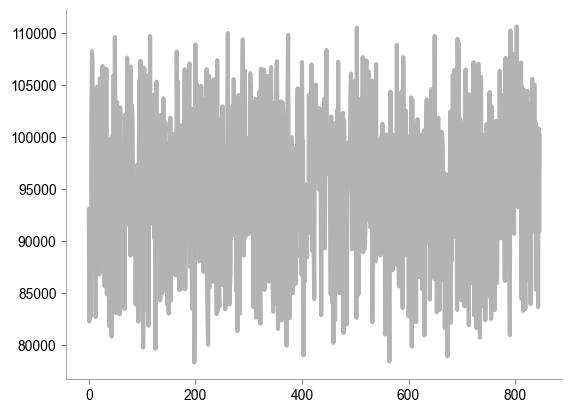

In [7]:
@jit
def ret_frus(mat):
    frus_mat = np.zeros(n_parcs)
    for i in range(n_parcs):
        for j in range(n_parcs):
            for k in range(n_parcs):
                if (i != j) and (i != k) and (j != k):
                    y = mat[i,j]*mat[i,k]*mat[j,k] < 0
                    frus_mat[i] += y
    return frus_mat / 3


frus_mat = ret_frus(cmat)
plt.plot(frus_mat)

In [3]:
with open('LSD.npy', 'rb') as lf:
    l = np.load(lf)
with open('PCB.npy', 'rb') as pf:
    p = np.load(pf)

<Axes: >

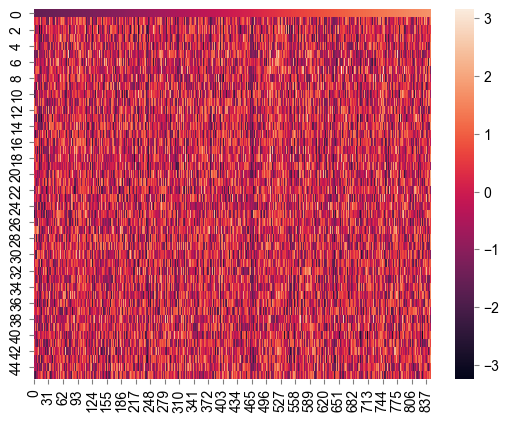

In [9]:
sns.heatmap(p)

In [6]:
d = {}
for mod in ['LSD', 'PCB']:
    d[mod] = rois.copy()
    for rest in ['rest1', 'rest2', 'rest3']:
        for sub in sorted(glob.glob('/home/ilkin/Documents/GitHub/datasci/fmri/' + f'difumo/{mod}/{rest}/*all*')):
            sub_name = sub.split('/')[-1][:3]
            mat = pd.read_csv(sub, delimiter=' ', header=None)[rois]
            corr = np.corrcoef(mat.to_numpy().T)
            frus = ret_frus(corr)
            d[mod] = np.vstack((d[mod], frus))
        print(rest, "complete")
l = d['LSD'][1:]
p = d['PCB'][1:]

NameError: name 'ret_frus' is not defined

<Axes: >

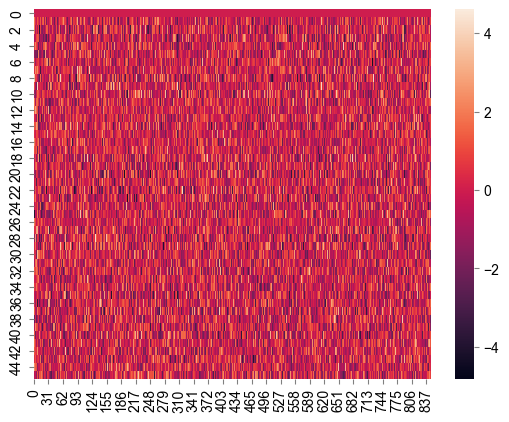

In [10]:
sns.heatmap(p - l)

In [4]:

p_values = []
for col1, col2 in zip(p[1:].T, l[1:].T):
    _, p_value = scipy.stats.ttest_rel(col1, col2)
    p_values.append(p_value)
rejected, adjusted_p_values = fdrcorrection(p_values)
# parr = np.array(p_values)
# plt.hist(parr[parr < (0.05 / 1024)])
np.array(adjusted_p_values)[np.array(adjusted_p_values) < 0.01]

array([0.00100379])

In [5]:
atlas = nilearn.datasets.fetch_atlas_difumo(dimension=1024, data_dir='.')
# plotting.plot_roi(atlas.maps, display_mode='ortho', cut_coords=None,
#                   )
atlas.maps

'./difumo_atlases/1024/2mm/maps.nii.gz'

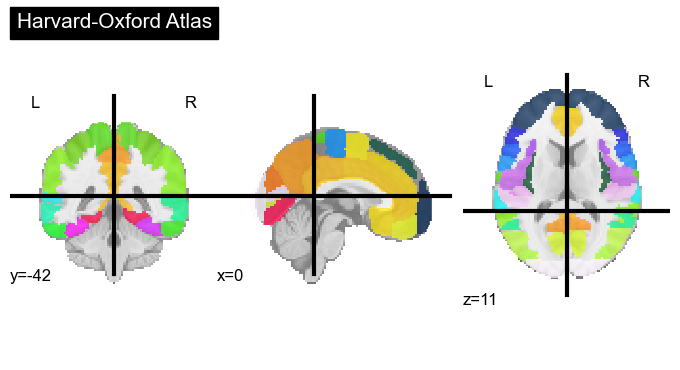

In [15]:
atlas1 = nilearn.datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
plotting.plot_roi(atlas1.maps, display_mode='ortho', cut_coords=None,
                  title="Harvard-Oxford Atlas")

In [17]:
len(atlas1.labels)

49

In [9]:
nilearn.image.get_data(atlas.maps).shape

(91, 109, 91)

In [6]:

sigrois = np.zeros(1024)
sigrois[rois[rejected]-1] += 1
sigrois = sigrois.astype(bool)
maps = nilearn.image.get_data(atlas.maps)

In [7]:
filtered = maps.copy()
filtered.shape

(104, 123, 104, 1024)

In [8]:
filtered[:,:,:,~sigrois] = 0


In [9]:
fil = filtered[:,:,:,sigrois]

In [10]:

func = nib.load(atlas.maps)

In [16]:
nilearn.image.binarize_img(atlas.maps)

: 

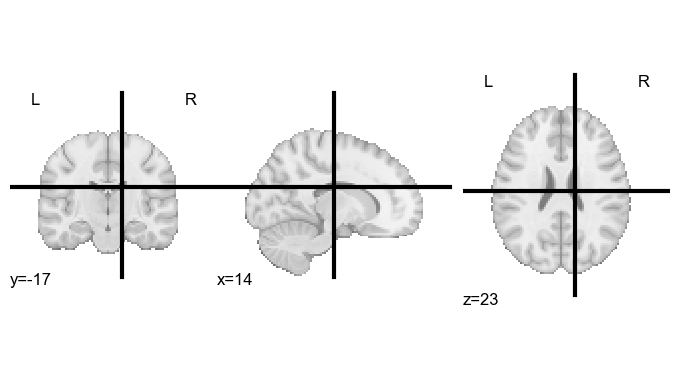

In [14]:

niimg = nib.Nifti1Image(fil[:,:,:,4], func.affine)
plotting.plot_roi(niimg)

In [18]:
filtered = maps[0,:,:,sigrois]

func = nib.load(atlas.maps)
niimg = nib.Nifti1Image(filtered, func.affine)
# nib.save(niimg, 'output.nii.gz')
plotting.plot_roi(niimg)

NameError: name 'maps' is not defined

In [3]:
plotting.plot_roi(atlas.maps)

DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See https://nilearn.github.io/stable/manipulating_images/input_output.html.

In [13]:
atlases = nilearn.datasets.fetch_atlas_difumo(dimension=1024)
atlases.labels[rois[rejected]-1]


rec.array([(  13, 'Superior parietal lobule anterior LH', 'DorsAttnB', 'DorsAttnA', 0.45914662, 0.40778581, 0.11923399),
           (  73, 'Angular gyrus postero-inferior LH', 'DefaultB', 'TempPar', 0.69584331, 0.17506248, 0.09716087),
           (  77, 'Supramarginal gyrus antero-inferior RH', 'SalVentAttnA', 'SalVentAttnA', 0.73105691, 0.07313701, 0.17842289),
           (  94, 'Supracalcarine cortex RH', 'VisCent', 'VisPeri', 0.72421376, 0.14827385, 0.12751717),
           (  99, 'Lateral ventricle RH', 'No network found', 'No network found', 0.39511027, 0.39952243, 0.20537107),
           ( 133, 'Occipitotemporal sulcus mid-anterior RH', 'DorsAttnB', 'DorsAttnA', 0.65167083, 0.32183573, 0.02647071),
           ( 153, 'Caudate', 'No network found', 'No network found', 0.78731153, 0.03456504, 0.17814494),
           ( 212, 'Cingulate anterior RH', 'DefaultB', 'DefaultA', 0.40388998, 0.58133544, 0.0147801 ),
           ( 266, 'Parieto-occipital sulcus anterior', 'VisCent', 'DefaultC',